# Distributed haloes generation simplified
<b>Author</b>: Natalie B. Hogg

We use `lenstronomy` to create an image produced by the so-called "distributed haloes" model, where we have a main lens modelled by an EPL profile, with a large number of NFW haloes along the line-of-sight, both in front of and behind the main lens. We draw the positions of the haloes from a plectrum-shaped volume whose radius is dependent on the number density of haloes and the comoving distances from observer to halo and observer to source. We obtain the number density of the haloes and their masses from a halo mass function computed using `colossus`. We use the multi-plane lensing functionality of `lenstronomy` to place the haloes along the line-of-sight.

We create a mock image that would be observed in this situation, and attempt to fit it with a model which includes an EPL main lens plus line-of-sight shear. We aim to show that the MCMC can correctly recover the predicted LOS shears. We find that a number of haloes break the tidal approximation and induce a flexion-like residual in the reconstructed image. With these beyond-tidal haloes removed from the population, the LOS shears are recovered perfectly.

**This notebook generates and saves the haloes**.

## Contents <a name="contents"></a>
1. [Set up](#setup)
2. [Create haloes](#create_haloes)
 1. [Mass](#mass)
 2. [Plectrum region](#plectrum)
 2. [Distances](#distance)
 3. [Remaining parameters](#lenstronomy)
3. [Plot the populated region](#plot)
4. [Compute the shears](#predict_shears)

## Set up <a name="setup"></a>

### Import packages

In [1]:
# computation
import numpy as np
import pandas as pd
import random as r
from scipy.interpolate import interp1d
from scipy.integrate import trapezoid

# plotting
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rc, rcParams, rcParamsDefault
from mpl_toolkits import mplot3d

# cosmology
from colossus.cosmology import cosmology as colcos
from colossus.lss import mass_function
from colossus.halo import concentration
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM, z_at_value
from astropy import constants as const
from astropy import units as u

# monitoring
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# this is where the figures will be saved
outpath  = r'/home/natalie/Documents/Projects/los_effects/figures/distributed_haloes/simple/' 
# outpath  = '/Users/pierrefleury/Documents/data/haloes/'

### Import `lenstronomy` packages

In [2]:
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Cosmo.lens_cosmo import LensCosmo

### Useful functions

In [3]:
def show_palette(colour):
    # function for displaying colour palettes
    sns.set_style('whitegrid')
    hex2rgb = []
    for k in colour:
        h = k.lstrip('#')
        hex2rgb.append(tuple(int(h[i:i + 2], 16) / 255.0 for i in (0, 2, 4)))
    return sns.palplot(hex2rgb)

def ellipticity(phi, q):
    # transforms orientation angle phi and aspect ratio q into complex ellipticity modulii e1, e2
    # phi and q must be passed as lists
    phi = np.array(phi)
    q = np.array(q)
    e1 = (1 - q)/(1 + q)*np.cos(2*phi)
    e2 = (1 - q)/(1 + q)*np.sin(2*phi)
    return list(e1), list(e2)

def distance_conversion(distance, conversion_type):
    # converts a distance *in Mpc* to Gpc, kpc, pc or m
    # careful! it doesn't sanity check your input
    if conversion_type == 'to Gpc':
        new_distance = distance/(10**3)
    elif conversion_type == 'to kpc':
        new_distance = distance*(10**3)
    elif conversion_type == 'to pc':
        new_distance = distance*(10**6)
    elif conversion_type == 'to m':
        new_distance = distance*(3.086*10**22)
    else:
        print('Unknown conversion type')
    return new_distance

def angle_conversion(angle, conversion_type):
    # converts an angle in arcsec to rad or rad to arcsec
    # careful! it doesn't sanity check your input
    conversion_factor = np.pi/(180*3600)
    if conversion_type == 'to arcsecs':
        new_angle = angle/conversion_factor
    elif conversion_type == 'to radians':
        new_angle = angle*conversion_factor
    else:
        print('Unknown conversion type')
    return new_angle

### Global plotting and display settings

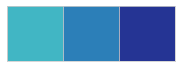

In [4]:
# contour plot colours
# thanks to colorbrewer for these palettes! https://colorbrewer2.org
green        = ['#a6dba0','#5aae61','#1b7837']
purple       = ['#c2a5cf', '#9970ab', '#762a83']
analogous    = ['#a0c3db', '#dbb7a0']
warm         = ['#fdcc8a', '#fc8d59', '#d7301f']
cool         = ['#41b6c4', '#2c7fb8', '#253494']

# have a look at a palette for example
show_palette(cool)

# set the seaborn style
sns.set_style('ticks')

# use TeX for plot labels
rc('text', usetex=True)
rc('font', family='serif')
rcParams.update({'font.size': 18})

### Start the Universe

In [5]:
cosmology = {'id': 'planck18', 'H0': 67.4, 'Om': 0.315}

colcos.setCosmology(cosmology['id'])

cosmo = FlatLambdaCDM(H0 = cosmology['H0'], Om0 = cosmology['Om']) 

G_Newton   = const.G.value # 6.67*10**-11 [m^3 / kg s^2]
clight     = const.c.value # 299792458 [m / s]
clight_kms = clight/1000   # 299792.458 [km / s]
solar_mass = const.M_sun.value # 1.988*10**30 [kg]
parsec     = const.pc.value # 3.08567758*10**16 [m]

def dC(redshift):
    """
    Returns the comoving distance at a given redshift in Mpc.
    """
    distance = cosmo.comoving_distance(redshift).value
    return distance

def Hubble(redshift):
    """
    Returns H(z) for a given redshift in km/s/Mpc.
    """
    Hofz = cosmo.H(redshift).value
    return Hofz

def dA(z1, z2):
    """
    Returns angular diameter distance between two redshifts in Mpc.
    """
    distance = cosmo.angular_diameter_distance_z1z2(z1, z2).value
    return distance

def redshift_converter(object_distance, units):
    object_redshift = z_at_value(cosmo.comoving_distance, object_distance*units, zmin = -0.0001, zmax=5.)
    return object_redshift

z_observer = 0.0
z_lens     = 0.5
z_source   = 1.5

z_hmf = z_lens

d_observer = 0.0
d_od       = dA(z_observer, z_lens)
d_os       = dA(z_observer, z_source)
d_ds       = dA(z_lens, z_source)

dc_source = dC(z_source)

print('\nThe Hubble parameter being used is {} km/s/Mpc.'.format(cosmo.h*100))
print('The redshifts of the observer, lens and the source are z = {}, z = {:.2} and z = {} respectively.'.format(z_observer, z_lens, z_source))
print('The angular distances between observer and lens, observer and source and lens and source are {:.2f} Mpc, {:.2f} Mpc and {:.2f} Mpc respectively.'.format(d_od, d_os, d_ds))


The Hubble parameter being used is 67.4 km/s/Mpc.
The redshifts of the observer, lens and the source are z = 0.0, z = 0.5 and z = 1.5 respectively.
The angular distances between observer and lens, observer and source and lens and source are 1300.92 Mpc, 1792.84 Mpc and 1012.28 Mpc respectively.


### Choose the number of haloes

**How many haloes should I have?** It depends on the minimum mass you want to use, or vice-versa.

<img src="number_of_haloes_vs_minimum_mass.png" alt="drawing" width="500" class = "center"/> 

In [6]:
# set the number of haloes along the line-of-sight and the minimum mass a halo can have
# these two numbers are related; see plot above

job_name = 'million'
lower_mass_limit = 8
 
# print('There are {} haloes along the line-of-sight between the observer and the source.'.format(halo_number))
print('The minimum mass a halo can have is 10^{} MSun/h.'.format(lower_mass_limit))

The minimum mass a halo can have is 10^8 MSun/h.


### Create main lens: `EPL` 
At this stage we only need to set an Einstein radius; the rest of the main lens parameters are set in the `distributed_haloes_analysis` notebook.

In [7]:
theta_E = 1.0 # arcsec

## Create haloes <a name="create_haloes"></a>

[Back to contents](#contents)

### Get the halo mass function using `colossus` <a name="mass"></a>

In [8]:
# define a mass range
mass_range = np.logspace(lower_mass_limit, 15, num=500) # [MSun/h]

# define the mass, 200 times the critical density of the Universe 
# this choice is consistent with lenstronomy internal definitions -- see lens_cosmo.py)
mdef = '200c' 

hmf_model = 'tinker08' # model for the HMF

# get the HMF
dNdlogM = mass_function.massFunction(mass_range, z_hmf, q_in='M', q_out='dndlnM', mdef=mdef, model=hmf_model)

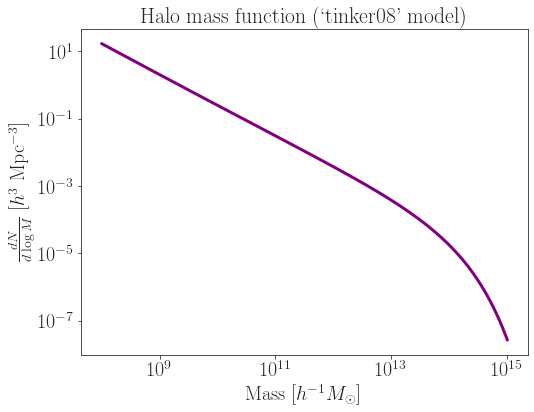

In [9]:
# plot the HMF
plt.figure(figsize = (8,6))
plt.title(r"Halo mass function (`{}' model)".format(hmf_model))
plt.plot(mass_range, dNdlogM, lw = 3, color = 'purple')
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('Mass [$h^{-1} M_{\odot}$]', fontsize = 20)
plt.ylabel(r'$\frac{dN}{d\log M}$ [$h^3$ Mpc$^{-3}$]', fontsize = 20)
plt.show()

### Relevant region of space to be considered

We start with a region of space that is a comoving cylinder with length $\chi_{\rm s}$ (comoving distance between the observer and the source) and radius $R_0$, which we fix in such a way that a point lens with mass $M$ at a comoving distance $R_0$ from the optical axis would produce a shear of magnitude $\varepsilon$ if it lied half-way ($\chi_{1/2}=\chi_{\rm s}/2$) between the observer and the source. This implies
$$
R_0
= \frac{r_{\rm E}}{\sqrt{\varepsilon}}
= \sqrt{\frac{GM\chi_{\rm s}}{c^2(1+z_{1/2})\varepsilon}}
$$

In [10]:
# compute R_0
M = 1e12 * solar_mass # [kg] 
eps = 1e-5
chis = dC(z_source) * 1e6 * parsec # [m]
z12 = z_at_value(cosmo.comoving_distance, cosmo.comoving_distance(z_source)/2)
R_0_m = np.sqrt(G_Newton * M * chis / clight**2 / (1 + z12) / eps) # [m]
R_0 = R_0_m / (1e6 * parsec) # [Mpc]

print('The maximum comoving radius R0 of the region is {:.3f} Mpc'.format(R_0))

The maximum comoving radius R0 of the region is 3.675 Mpc


In [11]:
n_c_little_h = trapezoid(dNdlogM/mass_range, x=mass_range) # [h^3/Mpc^3]

n_c = n_c_little_h/cosmo.h**3. # [Mpc^-3]

cylinder_halo_number = int(np.pi*n_c*(R_0**2.)*dc_source)

print('Number of haloes in cylinder: {:e}.'.format(cylinder_halo_number))

Number of haloes in cylinder: 1.135706e+07.


### Create halo dataframe <a name="distance"></a>

In [12]:
# create dataframe for halo parameters
# d is the comoving distance along the LOS to the halo [Mpc]
# z is the redshift to that distance
# r is the physical distance from the LOS [Mpc]
# x_phys and y_phys are the physical coordinates of the halo on the plane orthogonal to the LOS [Mpc]
# center_x and center_y are the coordinates of the halo in arcsec, passed to lenstronomy in kwargs_nfw [arcsec]
# mass is the mass of the halo [MSun]

haloes_dataframe = pd.DataFrame(columns = ['d', 'z', 'r', 'x_phys', 'y_phys','center_x', 'center_y', 'mass'])

### Create distances

In [13]:
halo_distance_list = np.random.uniform(d_observer, dc_source, cylinder_halo_number)

haloes_dataframe['d'] = halo_distance_list

### Convert to redshifts

In [14]:
z_grid   = np.linspace(z_observer, z_source, 101)

chi_grid = dC(z_grid)

z_of_chi   = interp1d(chi_grid, z_grid)

halo_redshift_list = z_of_chi(halo_distance_list)

haloes_dataframe['z'] = halo_redshift_list

### Halo transverse distances
Draw physical distance of each halo from LOS randomly on a disk.

In [15]:
r_sq = np.random.uniform(0.0, R_0**2., cylinder_halo_number)
r_com = np.sqrt(r_sq)

theta = np.random.uniform(0.0, 2.0*np.pi, cylinder_halo_number)

x_com = r_com*np.cos(theta)
y_com = r_com*np.sin(theta)

haloes_dataframe['r'] = r_com

haloes_dataframe['x_com'] = x_com
haloes_dataframe['y_com'] = y_com

haloes_dataframe['center_x'] = tqdm(angle_conversion(haloes_dataframe['x_com']/haloes_dataframe['d'], 'to arcsecs'))
haloes_dataframe['center_y'] = tqdm(angle_conversion(haloes_dataframe['y_com']/haloes_dataframe['d'], 'to arcsecs'))

  0%|          | 0/11357062 [00:00<?, ?it/s]

  0%|          | 0/11357062 [00:00<?, ?it/s]

### Get the lenstronomy `NFW` parameters <a name="lenstronomy"></a>

#### Mass

In [16]:
# draw halo masses from the original mass range, weighted by the HMF
halo_mass_inverse_h = r.choices(mass_range, dNdlogM, k = cylinder_halo_number) # [MSun/h]

# convert to units of MSun
halo_mass = list(np.array(halo_mass_inverse_h) * cosmo.h) # [MSun]

# save to df
haloes_dataframe['mass'] = halo_mass # [MSun]

#### Concentration

In [17]:
# use colossus to get the halo concentration
# concentration parameter is the ratio of the virial radius to the scale radius
# we use the same redshift as for the HMF so that the masses and concentrations are consistent

concentration_model = 'diemer15'

halo_concentration_inverse_h = concentration.concentration(M = np.array(halo_mass_inverse_h), 
                                                            mdef = mdef, 
                                                            z = z_hmf,  
                                                            model = concentration_model)

# convert to units of MSun
halo_concentration = list(np.array(halo_concentration_inverse_h) * cosmo.h) # [MSun]

# add to dataframe
haloes_dataframe['concentration'] = halo_concentration # [MSun]

#### Remove all haloes whose shear is below a certain threshold
For the sake of speed, we use the point lens approximation to compute the shear for this step, as it is faster than calling the `lenstronomy` function on each individual halo in a population this size.

In [18]:
def comoving_rE2(M, z, chi, chi_s):
    """
    Computes the comoving squared Einstein radius of a point lens in Mpc^2,
    M: mass of the lens in solar masses
    z: redshift of the lens
    chi: comoving distance to the observer in Mpc
    chis: comoving distance to the source in Mpc
    """
    
    mass_array = np.array(M)
    chi_array = np.array(chi)
    
    # convert in SI
    mass_array *= solar_mass # [kg]
    chi_array *= 1e6 * parsec
    chi_s *= 1e6 * parsec
    
    # compute the squared Einstein radius
    rE2 = 4*G_Newton*mass_array/clight**2.*(1 + np.array(z))*chi_array*(chi_s - chi_array)/chi_s # [m^2]
    rE2 /= (1e6 * parsec)**2 # [Mpc^2]
    
    return rE2

rE2 = comoving_rE2(halo_mass, halo_redshift_list, halo_distance_list, dc_source) #[Mpc^2]

point_lens_gamma_list = rE2/r_sq

haloes_dataframe['plg'] = point_lens_gamma_list

In [19]:
minimum_shear = 1e-5

small_gammas = [i for i in point_lens_gamma_list if i < minimum_shear]

gamma_percent = (len(small_gammas)/cylinder_halo_number)*100

print('There are {} haloes out of {} with a shear less than {} ({:.3f}%).'.format(len(small_gammas), cylinder_halo_number, minimum_shear, gamma_percent))
print('You\'re left with {} haloes!'.format(cylinder_halo_number-len(small_gammas)))

There are 11338224 haloes out of 11357062 with a shear less than 1e-05 (99.834%).
You're left with 18838 haloes!


In [20]:
shaped_haloes_dataframe = haloes_dataframe.loc[(haloes_dataframe['plg'] > minimum_shear)]

shaped_halo_number = len(shaped_haloes_dataframe)

In [21]:
# new quantities for iterating over
shaped_halo_redshift_list = shaped_haloes_dataframe['z'].to_list()
shaped_halo_mass          = shaped_haloes_dataframe['mass'].to_list()
shaped_halo_concentration = shaped_haloes_dataframe['concentration'].to_list()

# OS

#### Scale radius and deflection angle at scale radius
These should be in units without little h.

In [22]:
Rs_angle = []
alpha_Rs_os = []

for i in tqdm(range(shaped_halo_number)):
    # get the quantities for each halo's redshift
    lens_cosmo = LensCosmo(z_lens = shaped_halo_redshift_list[i], z_source = z_source, cosmo = cosmo)
    
    angles = lens_cosmo.nfw_physical2angle(M = shaped_halo_mass[i],
                                           c = shaped_halo_concentration[i])
    Rs_angle.append(float(angles[0]))
    alpha_Rs_os.append(float(angles[1]))

# add to the dataframe
shaped_haloes_dataframe['Rs'] = Rs_angle # [arcsec]
shaped_haloes_dataframe['alpha_Rs'] = alpha_Rs_os # [arcsec]

  0%|          | 0/18838 [00:00<?, ?it/s]

# Old method

In [23]:
# get the parameters needed for the lenstronomy kwargs and convert to a list of dictionaries
kwargs_nfw = shaped_haloes_dataframe[['Rs', 'alpha_Rs', 'center_x', 'center_y']].to_dict('records')

single_halo_lens_model = LensModel(lens_model_list = ['NFW'], z_source = z_source)

gamma1 = []
gamma2 = []
kappa  = []
alpha1 = []
alpha2 = []

# doing loops in this Fortran-esque style rather than via list comprehension avoids the need
# for some clunky remapping and cleaning of the lists produced via the latter method
# and it's also slightly faster (0.1 secs for 10k haloes) bc the remapping adds time

print('\nGetting convergence and shear')
for i in tqdm(range(shaped_halo_number)):
    single_gamma = single_halo_lens_model.gamma(x = 0.0, y = 0.0, kwargs = [kwargs_nfw[i]])
    gamma1.append(float(single_gamma[0]))
    gamma2.append(float(single_gamma[1]))
    
    single_kappa = single_halo_lens_model.kappa(x = 0.0, y = 0.0, kwargs = [kwargs_nfw[i]])
    kappa.append(float(single_kappa))
    
    single_alpha = single_halo_lens_model.alpha(x = 0.0, y = 0.0, kwargs = [kwargs_nfw[i]])
    alpha1.append(float(single_alpha[0]))
    alpha2.append(float(single_alpha[1]))

# shaped_haloes_dataframe['gamma1']  = gamma1 
# shaped_haloes_dataframe['gamma2']  = gamma2 
# shaped_haloes_dataframe['kappa']   = kappa
# shaped_haloes_dataframe['alpha1']  = alpha1
# shaped_haloes_dataframe['alpha2']  = alpha2

print(sum(alpha1))
print(sum(alpha2))


Getting convergence and shear


  0%|          | 0/18838 [00:00<?, ?it/s]

5.422203187680834
0.41062760919773444


## Checks<a name="checks"></a>

[Back to contents](#contents)

### Compute the convergence and shear of individual haloes at $x = y = 0$

In [24]:
# get the parameters needed for the lenstronomy kwargs and convert to a list of dictionaries
kwargs_nfw = shaped_haloes_dataframe[['Rs', 'alpha_Rs', 'center_x', 'center_y']].to_dict('records')

single_halo_lens_model = LensModel(lens_model_list = ['NFW'], z_source = z_source)

gamma1 = []
gamma2 = []
kappa  = []

for i in tqdm(range(shaped_halo_number)):
    single_gamma = single_halo_lens_model.gamma(x = 0.0, y = 0.0, kwargs = [kwargs_nfw[i]])
    gamma1.append(float(single_gamma[0]))
    gamma2.append(float(single_gamma[1]))
    
    single_kappa = single_halo_lens_model.kappa(x = 0.0, y = 0.0, kwargs = [kwargs_nfw[i]])
    kappa.append(float(single_kappa))
    
shaped_haloes_dataframe['gamma1']  = gamma1 
shaped_haloes_dataframe['gamma2']  = gamma2 
shaped_haloes_dataframe['kappa']   = kappa

  0%|          | 0/18838 [00:00<?, ?it/s]

### Compute the alpha term using MultiPlane for greater accuracy

In [25]:
multiplane_os_lens_model = LensModel(lens_model_list = ['NFW']*shaped_halo_number, 
                                     z_source = z_source,
                                     lens_redshift_list = shaped_haloes_dataframe['z'].to_list(),
                                     multi_plane=True)

mp_alpha_os = multiplane_os_lens_model.alpha(x = [0.0]*shaped_halo_number, 
                                             y = [0.0]*shaped_halo_number, 
                                             kwargs = kwargs_nfw)

expected_alpha1_os = mp_alpha_os[0][0]
expected_alpha2_os = mp_alpha_os[1][0]

In [26]:
print(expected_alpha1_os)
print(expected_alpha2_os)

6.250257215020619
3.9224828038700603


In [27]:
assert False

AssertionError: 

### Compute the shear of haloes at the Einstein radius of the main lens

In [ ]:
gamma1_thetaE_x = []
gamma2_thetaE_x = []

gamma1_thetaE_y = []
gamma2_thetaE_y = []

for i in tqdm(range(shaped_halo_number)):
    gamma_thetaE_x = single_halo_lens_model.gamma(x = theta_E, y = 0.0, kwargs = [kwargs_nfw[i]])
    gamma1_thetaE_x.append(float(gamma_thetaE_x[0]))
    gamma2_thetaE_x.append(float(gamma_thetaE_x[1]))
    gamma_thetaE_y = single_halo_lens_model.gamma(x = 0.0, y = theta_E, kwargs = [kwargs_nfw[i]])
    gamma1_thetaE_y.append(float(gamma_thetaE_y[0]))
    gamma2_thetaE_y.append(float(gamma_thetaE_y[1]))

### Histogram of the shear components

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=False, sharey=False)
fig.tight_layout()

for a, g, c in zip(ax, [gamma1, gamma2], [green[0], purple[0]]):
    a.hist(g, bins = 20, color = c)
    a.set_yscale('log')
    a.set_xlabel('$\gamma_{}$'.format([gamma1, gamma2].index(g)+1), fontsize=20)
    a.set_ylabel('Count', fontsize=20)
plt.savefig(outpath + job_name + '_gamma_os_histogram.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

### Histogram of the convergence

In [ ]:
bins = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plt.hist(kappa, bins = bins, color = analogous[0])
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('$\kappa$', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.savefig(outpath + job_name + '_kappa_os_histogram.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

### Safety net: remove haloes based on convergence
We check the convergence of each halo; if $\kappa > 1$, the halo is acting as a strong lens rather than a perturber and should be removed from the population. To be doubly sure we are getting rid of all the problematic haloes, we remove all with $\kappa > 0.5$.

In [ ]:
maximum_convergence = 0.5

bad_kappas = [i for i in kappa if i > maximum_convergence]

kappa_percent = (len(bad_kappas)/shaped_halo_number)*100

print('There are {} haloes out of {} with a convergence greater than {} ({:.1f}%).'.format(len(bad_kappas), shaped_halo_number, maximum_convergence, kappa_percent))

### Safety net II: remove haloes based on shear gradient

In [ ]:
def shear_gradient(g1_Ex, g2_Ex, g1_Ey, g2_Ey, g1, g2):
    Del_x_1  = g1_Ex - g1
    Del_x_2  = g2_Ex - g2
    Del_x_sq = (Del_x_1)**2. + (Del_x_2)**2.
    Del_y_1  = g1_Ey - g1
    Del_y_2  = g2_Ey - g2
    Del_y_sq = (Del_y_1)**2. + (Del_y_2)**2.
    Del      = np.sqrt((Del_x_sq + Del_y_sq)/(g1**2. + g2**2.))
    return Del

In [ ]:
Del = []

for i in tqdm(range(shaped_halo_number)):
    Del.append(shear_gradient(gamma1_thetaE_x[i],
                              gamma2_thetaE_x[i],
                              gamma1_thetaE_y[i],
                              gamma2_thetaE_y[i],
                              gamma1[i],
                              gamma2[i]))
    
shaped_haloes_dataframe['Del'] = Del

In [ ]:
%matplotlib inline
bins = [1e-3, 1e-2, 1e-1, 0.1e0, 0.2e0, 0.3e0, 0.4e0, 0.5e0, 0.6e0, 0.7e0, 0.8e0, 0.9e0, 1e0, 1e1]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plt.hist(Del, bins = bins, color = analogous[1])
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('$\Delta$', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.savefig(outpath + job_name + '_Del_histogram.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
maximum_Del = 0.1

bad_Dels = [i for i in Del if i > maximum_Del]

Del_percent = (len(bad_Dels)/shaped_halo_number)*100

print('There are {} haloes out of {} with a Del greater than {} ({:.2f}%).'.format(len(bad_Dels), shaped_halo_number, maximum_Del, Del_percent))

### Update the halo population

In [ ]:
# split the halo dataframe into good and bad
discarded_haloes_dataframe = shaped_haloes_dataframe.loc[(shaped_haloes_dataframe['kappa'] > maximum_convergence) | (shaped_haloes_dataframe['Del'] > maximum_Del)]
surviving_haloes_dataframe = shaped_haloes_dataframe.loc[(shaped_haloes_dataframe['kappa'] <= maximum_convergence) & (shaped_haloes_dataframe['Del'] <= maximum_Del)]

discarded_halo_number = len(discarded_haloes_dataframe)
surviving_halo_number = len(surviving_haloes_dataframe)

# check the split is correct
assert discarded_halo_number + surviving_halo_number == shaped_halo_number

## Plot the populated plectrum region<a name="plot"></a>
We can plot it in projection or in 3D.

[Back to contents](#contents)

In [ ]:
# for large numbers of haloes the plot below fills up
# so we can choose a percentage of the haloes to plot as an example
# and change the marker style depending on the number of points that will be plotted

plot_percent = 10
cut_percent = 100
    
cut = int((surviving_halo_number/100)*plot_percent)
cut_discarded = int((discarded_halo_number/100)*cut_percent)

if cut > 2000:
    marker = '.'
    alpha = 0.2
    size = (5,5)
else:
    marker = 'o'
    alpha = 1.0
    size=(10,10)

In [ ]:
%matplotlib inline

plt.figure(figsize = (10, 8))

plt.plot(surviving_haloes_dataframe['d'][:cut], surviving_haloes_dataframe['y_com'][:cut], 
         color = cool[2], ls = ' ', marker = marker, alpha = 0.2,
         label = 'Surviving haloes', rasterized=True)

plt.plot(discarded_haloes_dataframe['d'][:cut_discarded], discarded_haloes_dataframe['y_com'][:cut_discarded], 
         color = warm[2], ls = ' ', marker = marker, alpha = 0.2, 
         label = 'Discarded haloes', rasterized=True)

# plt.xlim(z_observer, z_source)
# plt.ylim(-0.5, 0.5)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Comoving distance from the observer $\chi$ [Mpc]', fontsize=20)
plt.ylabel('Comoving transverse position $y$ [Mpc]', fontsize=20)
plt.legend(loc = 'upper right', fontsize=20)

plt.savefig(outpath + job_name + '_region_rasterised_comoving.pdf', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

In [ ]:
# %matplotlib notebook
# fig = plt.figure(figsize=(12,12))
# ax = plt.axes(projection='3d')
# # plt.title('Plot shows {}\% of each population'.format(plot_percent))
# # ax.plot3D(d, np.zeros(len(d)), np.zeros(len(d)), ls = '--', color = 'k', alpha = 0.3)
# ax.scatter3D(surviving_haloes_dataframe['d'][:cut], 
#              surviving_haloes_dataframe['x_com'][:cut], 
#              surviving_haloes_dataframe['y_com'][:cut], color = cool[2],  marker = marker, alpha = 0.2);
# ax.scatter3D(discarded_haloes_dataframe['d'][:cut_discarded], 
#              discarded_haloes_dataframe['x_com'][:cut_discarded], 
#              discarded_haloes_dataframe['y_com'][:cut_discarded], color = warm[2],  marker = marker, alpha = 0.2);
# ax.set_xlabel('Comoving distance from the observer $\chi$ [Mpc]')
# ax.set_ylabel('Physical $x$ [Mpc]')
# ax.set_zlabel('Physical $y$ [Mpc]')

# plt.savefig(outpath + job_name + '_volume.pdf', dpi=300, bbox_inches='tight', transparent=True)

# plt.show()

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(2, 2, figsize=(10,8), sharey=False)

ax[0,0].hist(surviving_haloes_dataframe['r'], color = cool[2])
ax[0,0].set_xlabel('Distance of haloes from LOS [Mpc]')

ax[0,1].hist(surviving_haloes_dataframe['d'], color = cool[2])
ax[0,1].set_xlabel('Distance of haloes along LOS [Mpc]')

ax[1,0].hist(surviving_haloes_dataframe['x_com'], color = cool[2])
ax[1,0].set_xlabel('Physical $x$-coordinate of haloes')

ax[1,1].hist(surviving_haloes_dataframe['y_com'], color = cool[2])
ax[1,1].set_xlabel('Physical $y$-coordinate of haloes')

for a in ax.flat:
    a.set_ylabel('Count')
    
fig.tight_layout()

plt.show()

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# plt.hist(discarded_haloes_dataframe['d'], color = warm[2])
# plt.axvline(dC(z_lens), color = 'k', ls = '--', alpha = 0.3, label = 'Position of main lens')
# plt.xlim(0, dC(z_source))
# plt.xlabel('$\chi$ [Mpc]')
# plt.ylabel('Count')
# plt.legend()
# plt.show()

In [ ]:
# print('The masses and concentrations of the problematic haloes are, in descending mass order:\n')
# print(discarded_haloes_dataframe.sort_values('mass', ascending = False)[['mass', 'concentration']])
# print('\nThe shear parameters of the problematic haloes are:\n'.format(len(discarded_haloes_dataframe)))
# print(discarded_haloes_dataframe.sort_values('Del', ascending = False)[['gamma1', 'gamma2', 'Del']])
# print('\nThe shear parameters of the first {} surviving haloes are:\n'.format(len(discarded_haloes_dataframe)))
# print(surviving_haloes_dataframe.sort_values('Del', ascending = False)[['gamma1', 'gamma2', 'Del']][:len(discarded_haloes_dataframe)])

### Sanity check I: compare the Einstein radius of the halo with largest shear with its distance from the LOS 

In [ ]:
# get the index of the halo with largest gamma1
max_shear_halo_index = shaped_haloes_dataframe['gamma1'].idxmax()
max_shear_halo = shaped_haloes_dataframe.loc[[max_shear_halo_index]]

# compute the Einstein radius for this halo assuming it's a point mass
max_shear_halo_redshift = float(max_shear_halo['z'])
max_shear_halo_mass = float(max_shear_halo['mass'])
max_shear_halo_mass_kg = max_shear_halo_mass*solar_mass

prefactor = (4*G_Newton*max_shear_halo_mass_kg)/(clight**2.)

d_ds_m = distance_conversion(dA(max_shear_halo_redshift, z_source), 'to m')
d_os_m = distance_conversion(dA(z_observer, z_source), 'to m')
d_od_m = distance_conversion(dA(z_observer, max_shear_halo_redshift), 'to m')

distance_combination = d_ds_m/(d_os_m*d_od_m)

einstein_radius = np.sqrt(prefactor*distance_combination)

print('The Einstein radius of the halo with the largest gamma1 is {:.2f} arcsec.'.format(angle_conversion(einstein_radius, 'to arcsecs')))

max_shear_halo_x = float(max_shear_halo['center_x'])
max_shear_halo_y = float(max_shear_halo['center_y'])

euclid = np.sqrt(max_shear_halo_x**2. + max_shear_halo_y**2.)

print('The distance between the LOS and this halo is {:.2f} arcsec.'.format(euclid))

print('If these two numbers are roughly the same order of magnitude we are good to go.')

### Sanity check II: matter density in the plectrum volume

In [ ]:
total_mass = shaped_haloes_dataframe['mass'].sum()

volume = ((4*np.pi)/3)*(dC(z_source)/2)*(R_0**2.)

density = total_mass/volume

cgs_conversion = 6.7696e-41

density_cgs = density*cgs_conversion

obs_crit = cosmo.critical_density(z_observer).value

print('The matter density in the approximate comoving plectrum volume is {:.3e} g/cm^3.'.format(density_cgs))
print('The critical density of the Universe at z = {:.2} is {:.3e} g/cm^3.'.format(z_observer, obs_crit))
print('If these two quantities are roughly the same order of magnitude we are good to go.')

## Predict the LOS terms: all the haloes <a name="predict_shears"></a>

This is done for the complete haloes dataframe, problematic haloes included. The problematic haloes are removed and the shear terms recomputed in the `distributed_haloes_cutter` notebook.

[Back to contents](#contents)

In [ ]:
# make a dataframe to save them
shears_dataframe = pd.DataFrame(columns = ['gamma1_os', 'gamma2_os', 'kappa_os', 'alpha1_os', 'alpha2_os',
                                           'gamma1_od', 'gamma2_od', 'kappa_od', 'alpha1_od', 'alpha2_od',
                                           'gamma1_ds', 'gamma2_ds', 'kappa_ds',
                                           'gamma1_los', 'gamma2_los', 'kappa_los'])

# dummy row so we can write scalars directly to the df
shears_dataframe = shears_dataframe.append(pd.Series('dummy'), ignore_index=True)

In [ ]:
# we already computed the individual os terms, sum them to get the total os terms

expected_gamma1_os = sum(gamma1)
expected_gamma2_os = sum(gamma2)
expected_kappa_os  = sum(kappa)

shears_dataframe['gamma1_os'] = expected_gamma1_os
shears_dataframe['gamma2_os'] = expected_gamma2_os
shears_dataframe['kappa_os']  = expected_kappa_os
shears_dataframe['alpha1_os'] = expected_alpha1_os
shears_dataframe['alpha2_os'] = expected_alpha2_os

# OD

In [ ]:
foreground_haloes_dataframe = shaped_haloes_dataframe[shaped_haloes_dataframe['z'].between(z_observer, z_lens)]

foreground_halo_number = len(foreground_haloes_dataframe)
foreground_halo_redshift_list = foreground_haloes_dataframe['z'].to_list()
foreground_halo_mass          = foreground_haloes_dataframe['mass'].to_list()
foreground_halo_concentration = foreground_haloes_dataframe['concentration'].to_list()

In [ ]:
Rs_angle = []
alpha_Rs_od = []

for i in tqdm(range(foreground_halo_number)):
    # get the quantities for each halo's redshift
    lens_cosmo = LensCosmo(z_lens = foreground_halo_redshift_list[i], z_source = z_source, cosmo = cosmo)
    
    angles = lens_cosmo.nfw_physical2angle(M = foreground_halo_mass[i],
                                           c = foreground_halo_concentration[i])
    Rs_angle.append(float(angles[0]))
    alpha_Rs_od.append(float(angles[1]))

# add to the dataframe
foreground_haloes_dataframe['Rs'] = Rs_angle # [arcsec]
foreground_haloes_dataframe['alpha_Rs'] = alpha_Rs_od # [arcsec]

In [ ]:
kwargs_foreground_nfw = foreground_haloes_dataframe[['Rs','alpha_Rs','center_x','center_y']].to_dict('records')

od_lens_model = LensModel(lens_model_list = ['NFW'], z_source = z_source)

gamma1_od = []
gamma2_od = []
kappa_od  = []

for i in tqdm(range(foreground_halo_number)):
    gamma_od = od_lens_model.gamma(x = 0.0, y = 0.0, kwargs = [kwargs_foreground_nfw[i]])
    kappa_od_calc = od_lens_model.kappa(x = 0.0, y = 0.0, kwargs = [kwargs_foreground_nfw[i]])
    gamma1_od.append(float(gamma_od[0]))
    gamma2_od.append(float(gamma_od[1]))
    kappa_od.append(float(kappa_od_calc))
        
expected_gamma1_od = sum(gamma1_od)
expected_gamma2_od = sum(gamma2_od)
expected_kappa_od  = sum(kappa_od)

shears_dataframe['gamma1_od'] = expected_gamma1_od
shears_dataframe['gamma2_od'] = expected_gamma2_od
shears_dataframe['kappa_od']  = expected_kappa_od

In [ ]:
multiplane_od_lens_model = LensModel(lens_model_list = ['NFW']*len(foreground_haloes_dataframe), 
                                  z_source = z_lens, # notice we use the main lens redshift as the 'source'
                                  lens_redshift_list = foreground_halo_redshift_list,
                                  multi_plane=True)


mp_alpha_od = multiplane_od_lens_model.alpha(x = [0.0]*len(foreground_haloes_dataframe), 
                                             y = [0.0]*len(foreground_haloes_dataframe), 
                                             kwargs = kwargs_foreground_nfw)

expected_alpha1_od = mp_alpha_od[0][0]
expected_alpha2_od = mp_alpha_od[1][0]

shears_dataframe['alpha1_od'] = expected_alpha1_od
shears_dataframe['alpha2_od'] = expected_alpha2_od

In [ ]:
print(expected_alpha1_od, expected_alpha2_od)

# DS
Only the od and os components play a role in the source position correction, so we don't need to compute `alpha_ds`.

In [ ]:
background_haloes_dataframe = shaped_haloes_dataframe[shaped_haloes_dataframe['z'].between(z_lens, z_source)]

background_halo_number = len(background_haloes_dataframe)
background_halo_redshift_list = background_haloes_dataframe['z'].to_list()
background_halo_mass          = background_haloes_dataframe['mass'].to_list()
background_halo_concentration = background_haloes_dataframe['concentration'].to_list()

Rs_angle = []
alpha_Rs_ds = []

In [ ]:
for i in tqdm(range(background_halo_number)):
    # get the quantities for each halo's redshift
    lens_cosmo = LensCosmo(z_lens = background_halo_redshift_list[i], z_source = z_source, cosmo = cosmo)
    
    angles = lens_cosmo.nfw_physical2angle(M = background_halo_mass[i],
                                           c = background_halo_concentration[i])
    Rs_angle.append(float(angles[0]))
    alpha_Rs_ds.append(float(angles[1]))

# add to the dataframe
background_haloes_dataframe['Rs'] = Rs_angle # [arcsec]
background_haloes_dataframe['alpha_Rs'] = alpha_Rs_ds # [arcsec]

In [ ]:
kwargs_background_nfw = background_haloes_dataframe[['Rs','alpha_Rs','center_x','center_y']].to_dict('records')

ds_lens_model = LensModel(lens_model_list = ['NFW'], z_source = z_source)

gamma1_ds = []
gamma2_ds = []
kappa_ds  = []

for i in tqdm(range(background_halo_number)):
    gamma_ds = ds_lens_model.gamma(x = 0.0, y = 0.0, kwargs = [kwargs_background_nfw[i]])
    kappa_ds_calc = ds_lens_model.kappa(x = 0.0, y = 0.0, kwargs = [kwargs_background_nfw[i]])
    gamma1_ds.append(float(gamma_ds[0]))
    gamma2_ds.append(float(gamma_ds[1]))
    kappa_ds.append(float(kappa_ds_calc))
        
expected_gamma1_ds = sum(gamma1_ds)
expected_gamma2_ds = sum(gamma2_ds)
expected_kappa_ds  = sum(kappa_ds)

shears_dataframe['gamma1_ds'] = expected_gamma1_ds
shears_dataframe['gamma2_ds'] = expected_gamma2_ds
shears_dataframe['kappa_ds']  = expected_kappa_ds

In [ ]:
multiplane_ds_lens_model = LensModel(lens_model_list = ['NFW']*len(background_haloes_dataframe), 
                                  z_source = z_source,
                                  lens_redshift_list = background_halo_redshift_list,
                                  multi_plane=True)


mp_alpha_ds = multiplane_ds_lens_model.alpha(x = [0.0]*len(background_haloes_dataframe), 
                                             y = [0.0]*len(background_haloes_dataframe), 
                                             kwargs = kwargs_background_nfw)

expected_alpha1_ds = mp_alpha_ds[0][0]
expected_alpha2_ds = mp_alpha_ds[1][0]

shears_dataframe['alpha1_ds'] = expected_alpha1_ds
shears_dataframe['alpha2_ds'] = expected_alpha2_ds

### Get the LOS component

In [ ]:
expected_gamma1_LOS = expected_gamma1_os + expected_gamma1_od - expected_gamma1_ds
expected_gamma2_LOS = expected_gamma2_os + expected_gamma2_od - expected_gamma2_ds
expected_kappa_LOS  = expected_kappa_os  + expected_kappa_od  - expected_kappa_ds

shears_dataframe['gamma1_los'] = expected_gamma1_LOS
shears_dataframe['gamma2_los'] = expected_gamma2_LOS
shears_dataframe['kappa_los']  = expected_kappa_LOS

In [ ]:
print('\nThe predicted shear components for all haloes are:')
print('gamma_os  = ({:.3e}, {:.3e})'.format(expected_gamma1_os, expected_gamma2_os))
print('gamma_od  = ({:.3e}, {:.3e})'.format(expected_gamma1_od, expected_gamma2_od))
print('gamma_ds  = ({:.3e}, {:.3e})'.format(expected_gamma1_ds, expected_gamma2_ds))
print('gamma_LOS = ({:.3e}, {:.3e})'.format(expected_gamma1_LOS, expected_gamma2_LOS))

In [ ]:
print('\nThe predicted convergence components are:')
print('kappa_os  = {:.3e}.'.format(expected_kappa_os))
print('kappa_od  = {:.3e}.'.format(expected_kappa_od))
print('kappa_ds  = {:.3e}.'.format(expected_kappa_ds))
print('kappa_LOS = {:.3e}.'.format(expected_kappa_LOS))

## Save the final dataframes to file

In [ ]:
# write haloes to fits
haloes_fits = Table.from_pandas(shaped_haloes_dataframe)
haloes_fits.write(outpath + 'total_haloes_dataframe_' + job_name + '.fits', overwrite = True)

# write haloes to csv for quick looking at
# haloes_dataframe.to_csv(outpath + 'total_haloes_dataframe_' + job_name + '.csv', index = False)

# write shears to csv
shears_dataframe.to_csv(outpath + 'total_shears_dataframe_' + job_name + '.csv', index = False)

[Back to contents](#contents)